# VAE Anomaly Detection (Colab Notebook)

This Google Colab notebook implements **unsupervised anomaly detection using a Variational Autoencoder (VAE)**.

## Overview

* The VAE is trained **only on normal data**
* It learns a latent representation of normal samples
* Anomalies are detected using **reconstruction error**

## Workflow

1. Load and preprocess image data
2. Train a VAE using reconstruction loss + KL divergence
3. Track training metrics (total, reconstruction, KL loss)
4. Reconstruct inputs and compute reconstruction error
5. Flag samples as anomalous if error exceeds a fixed threshold

## Anomaly Criterion

```
Anomaly if: reconstruction_error > threshold
```

The threshold was selected empirically during evaluation.

## Visualizations

* Original vs reconstructed images
* Loss curves over epochs
* Optional PCA projection of the latent space

## Notes

* Best suited for scenarios where anomalous data is rare or unavailable during training
* Threshold tuning is critical for reliable performance

This notebook is intended for **experimentation, analysis, and demonstration** of VAE-based anomaly detection in Colab.

### Dataset

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?select=Training

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Anomaly_Detection

/content/gdrive/MyDrive/Anomaly_Detection


In [ ]:
# --- PyTorch Libraries ---
import torch
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.utils as vutils
from torch.utils.data import random_split

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


# --- Math Libraries ---
import numpy as np
import pandas as pd
import math
import random

# --- ML Libraries ---
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

# --- Image Handling Libraries ---
from PIL import Image

# --- MISC Libraries ---
import os
import kagglehub
import shutil
from tqdm.notebook import trange, tqdm
import json

# --- PyTorch Settings
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# --- Load Sample ---
# Image paths
giloma_path= 'data/archive/Testing/glioma/Te-glTr_0000.jpg'
meningioma_path = 'data/archive/Testing/meningioma/Te-meTr_0000.jpg'
non_tumor_path = 'data/archive/Testing/notumor/Te-noTr_0000.jpg'
pituitary_path = 'data/archive/Testing/pituitary/Te-piTr_0000.jpg'

# PIL Image
giloma_img = Image.open(giloma_path)
meningioma_img = Image.open(meningioma_path)
non_tumor_img = Image.open(non_tumor_path)
pituitary_img = Image.open(pituitary_path)


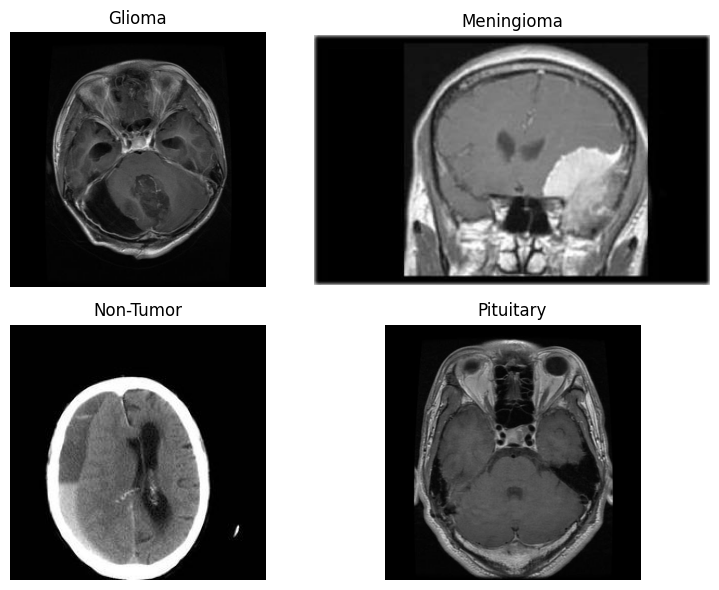

In [ ]:
# --- Visualize MRI Scans ---
def visualize_tumors(giloma_img, meningioma_img, non_tumor_img, pituitary_img):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    axes[0, 0].imshow(giloma_img)
    axes[0, 0].set_title("Glioma")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(meningioma_img)
    axes[0, 1].set_title("Meningioma")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(non_tumor_img)
    axes[1, 0].set_title("Non-Tumor")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(pituitary_img)
    axes[1, 1].set_title("Pituitary")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

visualize_tumors(giloma_img,meningioma_img,non_tumor_img,pituitary_img)

In [ ]:
# --- Training Samples ---

print('=== Training Samples ===\n')
train_samples = 0
len(os.listdir('data/archive/Training/'))
for tumour in os.listdir('data/archive/Training/'):
  path = os.path.join('data/archive/Training/',tumour)
  train_samples += len(os.listdir(path))
  print(f'{tumour} samples: {len(os.listdir(path))}')

print(f'\nTotal Training Samples: {train_samples}')

=== Training Samples ===

pituitary samples: 1457
notumor samples: 1595
meningioma samples: 1339
glioma samples: 1321

Total Training Samples: 5712


In [ ]:
# --- Training Samples ---

print('=== Testing Samples ===\n')
test_samples = 0
len(os.listdir('data/archive/Testing/'))
for tumour in os.listdir('data/archive/Testing/'):
  path = os.path.join('data/archive/Testing/',tumour)
  test_samples += len(os.listdir(path))
  print(f'{tumour} samples: {len(os.listdir(path))}')

print(f'\nTotal Testing Samples: {test_samples}')

=== Testing Samples ===

glioma samples: 300
meningioma samples: 306
pituitary samples: 300
notumor samples: 405

Total Testing Samples: 1311


In [ ]:
# --- Custom PyTorch Dataset ---

class TumourDataset(Dataset):
  def __init__(self,paths,transform):
    self.paths = paths
    self.transform = transform

  def __len__(self):
    return len(self.paths)

  def __getitem__(self,idx):

    path = self.paths[idx]
    image = torchvision.io.read_image(path)

    image = self.transform(image)

    return image





In [ ]:
# --- Defining Transform ---
import torchvision.transforms as transform


transform = transform.Compose([
    T.Lambda(lambda x: x[:3, :, :]),  # RGBA → RGB
    T.Grayscale(num_output_channels=1),
    T.Resize((256, 256)),
    T.ConvertImageDtype(torch.float32),
])


In [ ]:
# --- Train paths ---
train_notumor_dir = 'data/archive/Training/notumor'
train_notumor_paths = [
    os.path.join(train_notumor_dir, f)
    for f in os.listdir(train_notumor_dir)
]

train_anomaly_dirs = [
    'data/archive/Training/glioma',
    'data/archive/Training/meningioma',
    'data/archive/Training/pituitary'
]

train_anomaly_paths = []
for d in train_anomaly_dirs:
    train_anomaly_paths.extend(
        [os.path.join(d, f) for f in os.listdir(d)]
    )


# --- Test paths ---
test_notumor_dir = 'data/archive/Testing/notumor'
test_notumor_paths = [
    os.path.join(test_notumor_dir, f)
    for f in os.listdir(test_notumor_dir)
]

test_anomaly_dirs = [
    'data/archive/Testing/glioma',
    'data/archive/Testing/meningioma',
    'data/archive/Testing/pituitary'
]

test_anomaly_paths = []
for d in test_anomaly_dirs:
    test_anomaly_paths.extend(
        [os.path.join(d, f) for f in os.listdir(d)]
    )


# --- Datasets ---
train_notumor = TumourDataset(train_notumor_paths, transform)
test_notumor  = TumourDataset(test_notumor_paths, transform)

train_anomaly = TumourDataset(train_anomaly_paths, transform)
test_anomaly  = TumourDataset(test_anomaly_paths, transform)

print("Train normal:", len(train_notumor))
print("Train anomaly:", len(train_anomaly))




print("Test no tumor:", len(test_notumor))
print("Test anomaly:", len(test_anomaly))



Train normal: 1595
Train anomaly: 4117
Test no tumor: 405
Test anomaly: 906


In [ ]:
# --- DataLoaders ---
train_notumor_loader = DataLoader(
    train_notumor,
    batch_size=16,
    shuffle=True
)

test_notumor_loader = DataLoader(
    test_notumor,
    batch_size=16,
    shuffle=False
)


train_anomaly_loader = DataLoader(
    train_anomaly,
    batch_size=16,
    shuffle=False
)


test_anomaly_loader = DataLoader(
    test_anomaly,
    batch_size=16,
    shuffle=False
)



Train image shape: torch.Size([1, 256, 256])
Anomaly image shape: torch.Size([1, 256, 256])



(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

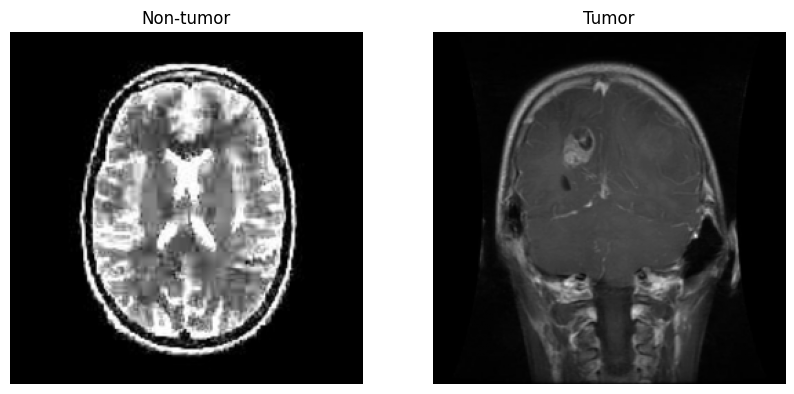

In [ ]:
# --- Testing Samples from train and test set ---

train_img = train_notumor[0]
anomaly_img = train_anomaly[0]

print(f'Train image shape: {train_img.shape}')
print(f'Anomaly image shape: {anomaly_img.shape}\n')

fig, axes = plt.subplots(1,2, figsize=(10, 6))

axes[0].imshow(train_img.squeeze(0),cmap='gray')
axes[0].set_title("Non-tumor")
axes[0].axis("off")

axes[1].imshow(anomaly_img.squeeze(0),cmap = 'gray')
axes[1].set_title("Tumor")
axes[1].axis("off")

### VAE

In [ ]:
# --- Encoder Convolutional Block ---
class EncoderBlock(nn.Module):
  """Convolutional Block for Encoder"""
  def __init__(self,in_c,out_c):
    super().__init__()

    # Sample input: (b,1,256,256)

    # --- Layer 1 ---
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_c,out_c,kernel_size=3,stride=2,padding=1), # (b,out_c,128,128)
      nn.BatchNorm2d(out_c),
      nn.LeakyReLU(0.2,inplace=True)
    )

    # --- Layer 2 ---
    self.layer2 = nn.Sequential(
      nn.Conv2d(out_c,out_c,kernel_size=3,stride=2,padding=1),  # (b,out_c,64,64)
      nn.BatchNorm2d(out_c),
      nn.LeakyReLU(0.2,inplace=True)
    )

    # --- Shortcut ---
    self.shortcut = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3, stride=4, padding=1), # (b,out_c,256,256) -> (b,out_c,64,64)
      nn.BatchNorm2d(out_c)
    )

    # --- Activation Function ---
    self.activation = nn.LeakyReLU(0.2, inplace=True)

  def forward(self,x):
    # x: (b,out_c,256,256)
    residual = self.shortcut(x) # Extract shortcut: (b,1,64,64)

    # pass input through conv block
    x = self.layer1(x) # x: (b,out_c,256,256) -> (b,out_c,128,128)
    x = self.layer2(x) # x: (b,out_c,128,128) -> (b,out_c,64,64)

    return self.activation(x + residual) # add residual to conv block output



class Encoder(nn.Module):
  """ Takes some input X and downsamples to a compressed version """
  def __init__(self,channels,ch=256,z = 32):
    super().__init__()

    self.conv1 = nn.Conv2d(channels, ch, 3, 1, 1) # (b,256,256,256)

    # --- Pass through Convolutional Blocks ---
    self.block1 = EncoderBlock(ch,ch) # (b,ch,64,64)
    self.block2 = EncoderBlock(ch,ch*2) # (b,ch*2,16,16)
    self.block3 = EncoderBlock(ch*2,ch*4) # (b,ch*4,4,4)

    self.conv_mu = nn.Conv2d(ch * 4, out_channels= z, kernel_size=1,stride = 1)
    self.conv_logvar = nn.Conv2d(ch * 4, out_channels= z, kernel_size=1,stride = 1)

  def sample_latent(self,mu,logvar):
    std = torch.exp(0.5*logvar) # Compute the log variance
    epsilon = torch.randn_like(std) # Sample from the standard normal distribution N(0,1) of the same shape as the std

    return mu + epsilon * std # return sample

  def forward(self,x):
    x = self.conv1(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)

    mu = self.conv_mu(x)
    logvar = self.conv_logvar(x)

    z = self.sample_latent(mu, logvar)


    return z,mu,logvar


In [ ]:
# --- Test Encoder ---

encoder = Encoder(channels=1)

z,mu,logvar = encoder(train_img.unsqueeze(1))

# (batch,channels,height,width)
print(f'Mean vector: {mu.shape}')
print(f'Log variance vector: {mu.shape}')
print(f'Encoding: {z.shape}')

Mean vector: torch.Size([1, 32, 4, 4])
Log variance vector: torch.Size([1, 32, 4, 4])
Encoding: torch.Size([1, 32, 4, 4])


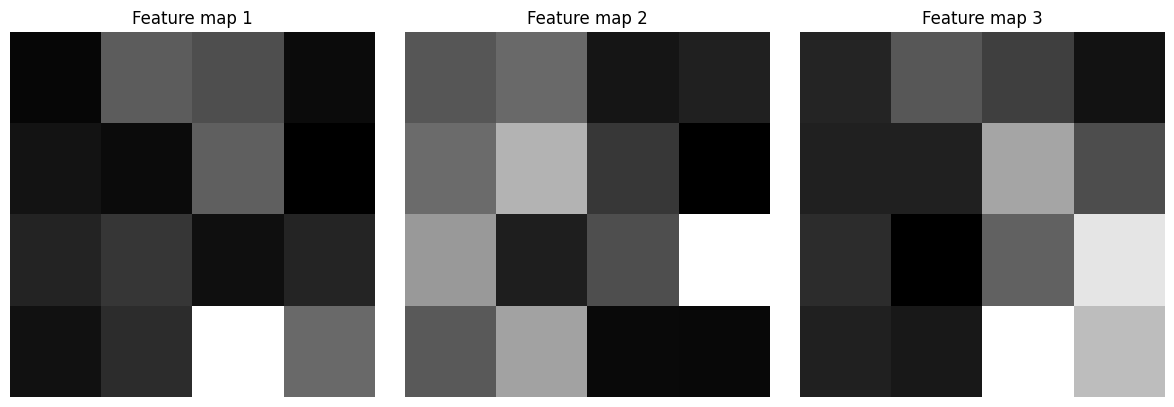

In [ ]:
# --- Visualizing Encoding ---

with torch.no_grad(): # Note we will manually pass the test image to avoid the flattening
    x0 = encoder.conv1(train_img.unsqueeze(1))
    x1 = encoder.block1(x0)
    x2 = encoder.block2(x1)
    x3 = encoder.block3(x2)  # (1, 128, 4, 4)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    feature = x3[0, i].cpu()  # batch 0, channel i
    axes[i].imshow(feature, cmap="gray")
    axes[i].set_title(f"Feature map {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# --- Decoder Block ---
class DecoderBlock(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.block = nn.Sequential(
      nn.ConvTranspose2d(
        in_c, out_c,
        kernel_size=4,
        stride=2,
        padding=1
        ),
      nn.BatchNorm2d(out_c),
      nn.LeakyReLU(0.2, inplace=True)
  )

  def forward(self, x):
    return self.block(x)


class Decoder(nn.Module):
  def __init__(self,channels,ch=256,z=32):
    super().__init__()

    # Initial : # (b,1,4,4)
    # self.conv1 = nn.ConvTranspose2d(z,4*ch,kernel_size=4,stride=1)

    self.block1 = DecoderBlock(z, 4 * ch)   # 4 → 8
    self.block2 = DecoderBlock(4 * ch, 2 * ch)   # 8 → 16
    self.block3 = DecoderBlock(2 * ch, ch)       # 16 → 32
    self.block4 = DecoderBlock(ch, ch // 2)      # 32 → 64
    self.block5 = DecoderBlock(ch // 2, ch // 4) # 64 → 128
    self.block6 = DecoderBlock(ch // 4, ch // 8) # 128 → 128

    self.out = nn.Sequential(
      nn.Conv2d(ch // 8, channels, kernel_size=3, padding=1),
      nn.Sigmoid()
    )

  def forward(self,z):

    # x = self.conv1(z)

    x = self.block1(z)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)

    return self.out(x)


decoding: torch.Size([1, 1, 256, 256])


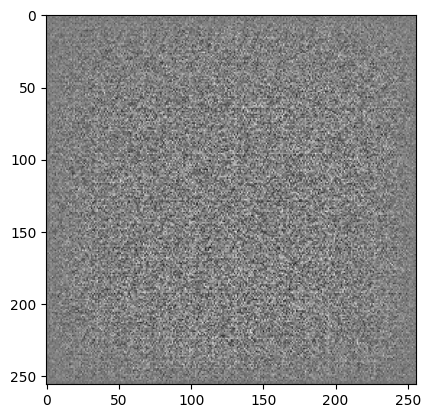

In [ ]:
# --- Testing Sample Decoding ---
decoder = Decoder(channels=1)

z = encoder.sample_latent(mu,logvar)
decoding = decoder(z)
print(f'decoding: {decoding.shape}')
plt.imshow(decoding.squeeze().detach().numpy(),cmap = 'gray')

In [ ]:
# --- Variational AutoEncoder ---
class VAE(nn.Module):
  def __init__(self,channel_in,ch = 256,z = 32):
    super().__init__()
    self.encoder = Encoder(channels=channel_in, ch=ch, z=z)
    self.decoder = Decoder(channels=channel_in, ch=ch, z=z)

  def forward(self, x):
    z, mu, logvar = self.encoder(x)

    # Only sample during training or when we want to generate new images
    # just use mu otherwise
    if self.training:
      decoding = self.decoder(z)
    else:
      decoding = self.decoder(mu)

    return decoding, mu, logvar

In [ ]:
# --- VAE Loss ---
def vae_loss(recon, x, mu, logvar, beta=0.5):
    # Mean reconstruction loss per pixel
    recon_loss = F.mse_loss(recon, x, reduction='mean')

    # KL divergence (per sample)
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl.sum(dim=1).mean()

    return recon_loss + beta * kl_loss, kl_loss*beta, recon_loss


In [ ]:
# --- Testing Loss Function ---
train_img = train_notumor[0].unsqueeze(1).to(device)

vae = VAE(channel_in=1,z = 64).to(device)

recon,mu,logvar = vae(train_img)

loss,kl_loss,recon_loss = vae_loss(recon,train_img,mu,logvar,beta = 0.0001)
print(f'Loss: {loss}')
print(f'KL loss: {kl_loss}')
print(f'Reconstruction loss: {recon_loss}')

Loss: 0.1876034140586853
KL loss: 0.0017425360856577754
Reconstruction loss: 0.18586087226867676


In [ ]:
# --- Define Model and Optimizer ---
vae = VAE(channel_in=1,z = 32).to(device)
optimizer = torch.optim.Adam(vae.parameters(),lr = 0.0001,betas=(0.5,0.999))

In [ ]:
n_epochs = 20

train_loss_log = []
test_loss_log = []

train_kl_losses = []
train_recon_losses = []

test_kl_losses = []
test_recon_losses = []

for epoch in range(n_epochs):
    vae.train()
    train_loss = 0.0

    for image in tqdm(train_notumor_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
        image = image.to(device)

        recon, mu, logvar = vae(image)
        loss, kl_loss, recon_loss = vae_loss(recon, image, mu, logvar,beta = 0.0001)

        train_kl_losses.append(kl_loss.item())
        train_recon_losses.append(recon_loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_notumor_loader)
    train_loss_log.append(train_loss)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train Loss: {train_loss:.4f} | "
    )


Epoch 1/20 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/20 [Test]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.0084 (Recon: 0.0059, KL: 0.0025) | Test Loss: 0.0094 (Recon: 0.0074, KL: 0.0020)


Epoch 2/20 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/20 [Test]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 002 | Train Loss: 0.0085 (Recon: 0.0059, KL: 0.0025) | Test Loss: 0.0092 (Recon: 0.0072, KL: 0.0020)


Epoch 3/20 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/20 [Test]:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 003 | Train Loss: 0.0085 (Recon: 0.0060, KL: 0.0025) | Test Loss: 0.0093 (Recon: 0.0073, KL: 0.0020)


Epoch 4/20 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# --- Save Model ---
os.makedirs("model", exist_ok=True)
torch.save(vae.state_dict(), "model/vae_model_best.pth")

In [ ]:
# --- Save Logs ---
save_path = "vae_log"
os.makedirs(save_path, exist_ok=True)

train_loss_path = os.path.join(save_path,'train_loss')
train_kl_path = os.path.join(save_path,'train_kl_loss')
train_recon_path = os.path.join(save_path,'train_recon_loss')

with open(os.path.join(save_path, "train_loss.json"), "w") as f:
    json.dump(train_loss_log, f)

with open(os.path.join(save_path, "train_kl_loss.json"), "w") as f:
    json.dump(train_kl_losses, f)

with open(os.path.join(save_path, "train_recon_loss.json"), "w") as f:
    json.dump(train_recon_losses, f)



In [ ]:
# --- Load Model ---
vae = VAE(channel_in=1,z = 32).to(device)
state_dict = torch.load('model/vae_model_best.pth',map_location=device)
vae.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# --- Load Loggers ---
save_path = "vae_log"

def load_json(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return []

train_loss_log = load_json(os.path.join(save_path, "train_loss.json"))
train_kl_loss = load_json(os.path.join(save_path, "train_kl_loss.json"))
train_recon_loss = load_json(os.path.join(save_path, "train_recon_loss.json"))



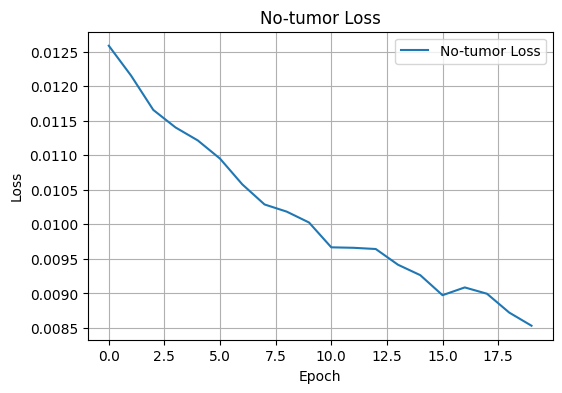

In [ ]:
# --- Visualize Loss ---
plt.figure(figsize=(6,4))

plt.plot(train_loss_log, label="No-tumor Loss")

plt.title("No-tumor Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


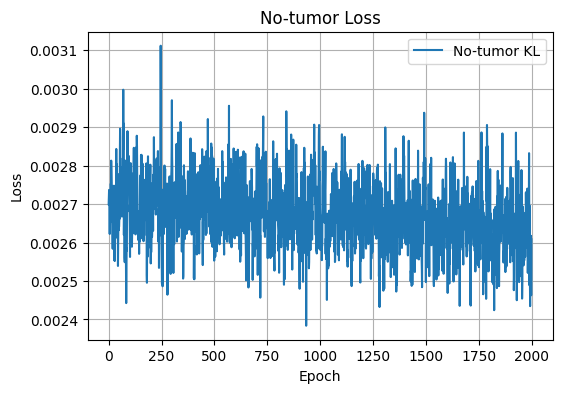

In [ ]:
# --- Visualize KL Loss ---
plt.figure(figsize=(6,4))

plt.plot(train_kl_loss, label="No-tumor KL")

plt.title("No-tumor KL Loss (Per batch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

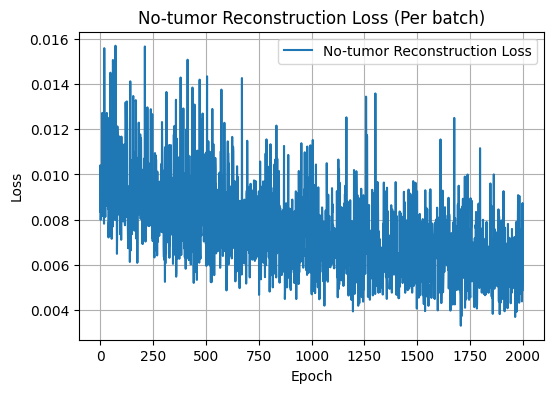

In [ ]:
# --- Visualize Reconstruction Loss ---
plt.figure(figsize=(6,4))

plt.plot(train_recon_loss, label="No-tumor Reconstruction Loss")

plt.title("No-tumor Reconstruction Loss (Per batch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# --- Sample for Test Batch ---
dataiter = iter(test_notumor_loader)
test_images = next(dataiter)

In [ ]:
# --- Sample from test images ---
vae.eval()
recon_data, mu, logvar = vae(test_images.to(device))

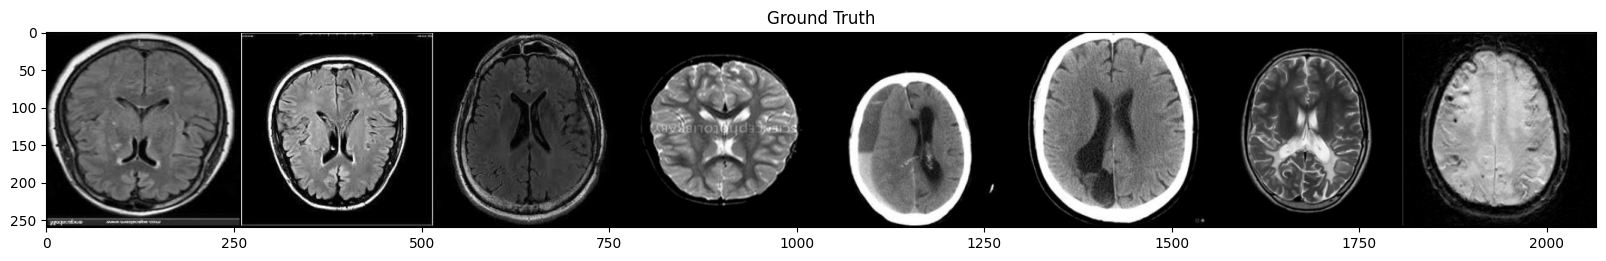

In [ ]:
# --- Visualize Ground Truth ---
plt.figure(figsize = (20,10))
plt.title('Ground Truth')
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

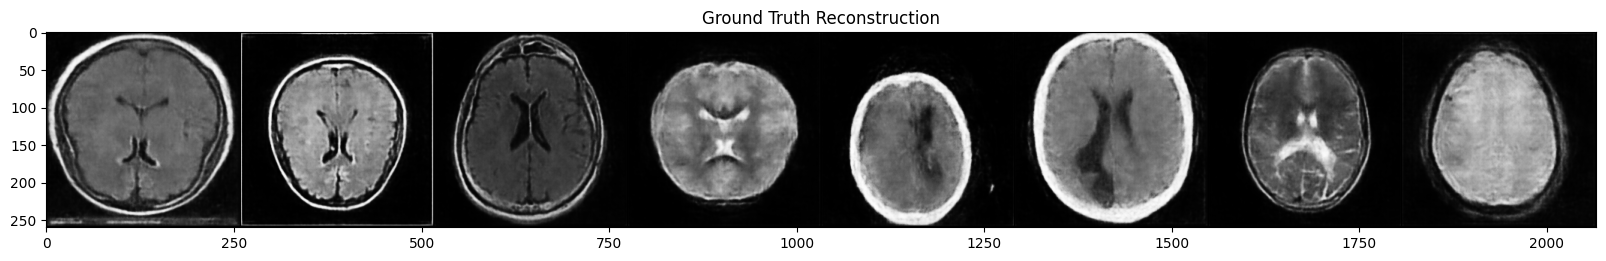

In [ ]:
# --- Visualize Reconstruction ---
plt.figure(figsize = (20,10))
plt.title('Ground Truth Reconstruction')
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

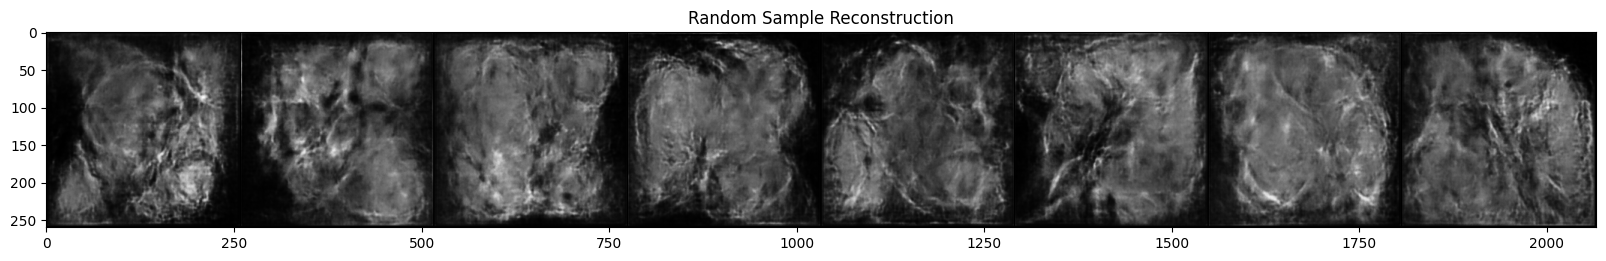

In [ ]:
# --- Visualize Random Samples ---
rand_samp = vae.decoder(torch.randn_like(mu))
plt.figure(figsize = (20,10))
plt.title('Random Sample Reconstruction')
out = vutils.make_grid(rand_samp.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
def test_model(model, dataloader, device, beta=0.001):
  model = model.to(device)
  model.eval()

  recon_scores = []
  kl_scores = []
  total_scores = []

  with torch.no_grad():
    for image in tqdm(dataloader, desc="Evaluating", leave=False):
      image = image.to(device)

      # Forward pass
      recon, mu, logvar = model(image)

      # ---------- Reconstruction error (per image) ----------
      recon_err = F.mse_loss(recon, image, reduction="none")
      recon_err = recon_err.flatten(1).mean(dim=1)  # [B]

      # ---------- KL divergence (per image) ----------
      kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
      kl = kl.flatten(1).sum(dim=1)   # [B]

      # ---------- Final anomaly score ----------
      score = recon_err + beta * kl

      recon_scores.extend(recon_err.cpu().numpy())
      kl_scores.extend(kl.cpu().numpy())
      total_scores.extend(score.cpu().numpy())

  return {
        "recon": np.array(recon_scores),
        "kl": np.array(kl_scores),
        "score": np.array(total_scores)
    }


In [ ]:
normal_scores = test_model(
    vae, test_notumor_loader, device
)

anomaly_scores = test_model(
    vae, test_anomaly_loader, device
)


Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

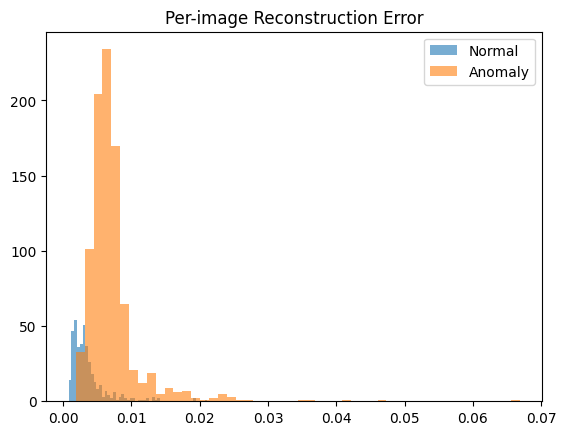

In [ ]:
# --- Visualize Reconstruction Overlap
plt.hist(normal_scores['recon'], bins=50, alpha=0.6, label="Normal")
plt.hist(anomaly_scores['recon'], bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.title("Per-image Reconstruction Error")
plt.show()


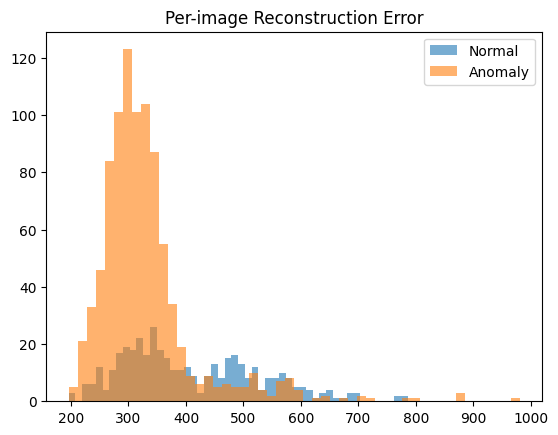

In [ ]:
# --- Visualize KL Overlap
plt.hist(normal_scores['kl'], bins=50, alpha=0.6, label="Normal")
plt.hist(anomaly_scores['kl'], bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.title("Per-image Reconstruction Error")
plt.show()


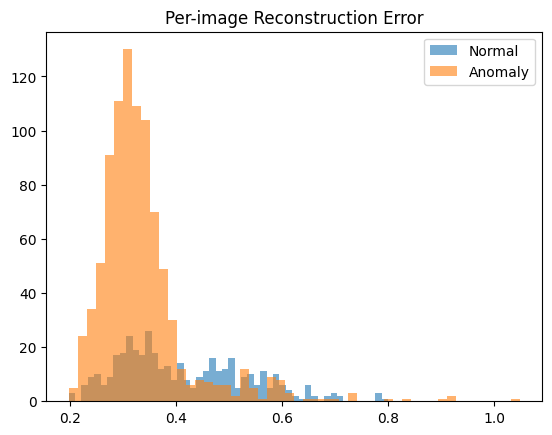

In [ ]:
# --- Visualize Score Overlap
plt.hist(normal_scores['score'], bins=50, alpha=0.6, label="Normal")
plt.hist(anomaly_scores['score'], bins=50, alpha=0.6, label="Anomaly")
plt.legend()
plt.title("Per-image Reconstruction Error")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
for key in ["recon", "kl", "score"]:
    y_true = np.concatenate([
      np.zeros(len(normal_scores[key])),
      np.ones(len(anomaly_scores[key]))
  ])

    y_scores = np.concatenate([
        normal_scores[key],
        anomaly_scores[key]
    ])
    auc = roc_auc_score(y_true, y_scores)
    print(f"{key} AUROC: {auc:.4f}")


recon AUROC: 0.8620
kl AUROC: 0.2811
score AUROC: 0.2947


In [ ]:
# --- Extract percentiles ---

percentile = 90

recon_thresh = np.percentile(normal_scores['recon'],percentile)

print(f'Reconstruction percentile: {recon_thresh}') # Any reconstruction loss greater than this == anomaly

Reconstruction percentile: 0.006555626634508371


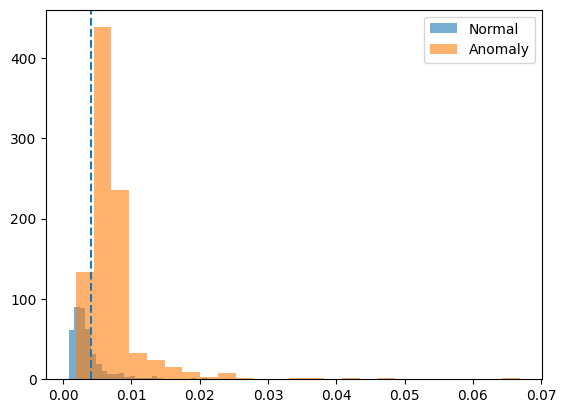

In [ ]:
plt.hist(normal_scores['recon'], bins=25, alpha=0.6, label="Normal")
plt.hist(anomaly_scores['recon'], bins=25, alpha=0.6, label="Anomaly")
plt.axvline(recon_thresh, linestyle="--")
plt.legend()


In [ ]:
# --- Giloma image ---

# Load and transform image
giloma_img = torchvision.io.read_image(giloma_path)
giloma_img = transform(giloma_img).unsqueeze(1).to(device)

meningioma_img = torchvision.io.read_image(meningioma_path)
meningioma_img = transform(meningioma_img).unsqueeze(1).to(device)

pituitary_img = torchvision.io.read_image(pituitary_path)
pituitary_img = transform(pituitary_img).unsqueeze(1).to(device)

notumor_img = torchvision.io.read_image(non_tumor_path)
notumor_img = transform(notumor_img).unsqueeze(1).to(device)

In [ ]:
def compute_recon_scores(recon, original):
    """
    recon, original: [B, C, H, W]
    returns: tensor [B]
    """
    recon_err = F.mse_loss(recon, original, reduction="none")
    recon_err = recon_err.flatten(1).mean(dim=1)
    return recon_err


In [ ]:
def is_anomaly(recon_loss,recon_thresh = recon_thresh):
    return bool(recon_loss > recon_thresh)

In [ ]:
# --- Testing Anomaly Threshold

vae.eval()
with torch.no_grad():
    giloma_recon, _, _ = vae(giloma_img)
    meningioma_recon, _, _ = vae(meningioma_img)
    pituitary_recon, _, _ = vae(pituitary_img)
    notumor_recon, _, _ = vae(notumor_img)

giloma_recon_score = compute_recon_scores(giloma_recon, giloma_img)
meningioma_recon_score = compute_recon_scores(meningioma_recon, meningioma_img)
pituitary_recon_score = compute_recon_scores(pituitary_recon, pituitary_img)
notumor_recon_score = compute_recon_scores(notumor_recon, notumor_img)

print(f'=== Giloma Test ====')
print("Reconstruction score:", giloma_recon_score.item())
print(f"Threshold/Percentile: {recon_thresh} / {percentile}%")
print("Anomaly:", is_anomaly(giloma_recon_score.item(), recon_thresh))


print(f'\n=== Meningoma Test ====')
print("Reconstruction score:", meningioma_recon_score.item())
print(f"Threshold/Percentile: {recon_thresh} / {percentile}%")
print("Anomaly:", is_anomaly(meningioma_recon_score.item(), recon_thresh))


print(f'\n=== Pituitary Test ====')
print("Reconstruction score:", pituitary_recon_score.item())
print(f"Threshold/Percentile: {recon_thresh} / {percentile}%")
print("Anomaly:", is_anomaly(pituitary_recon_score.item(), recon_thresh))

print(f'\n=== Notumor Test ====')
print("Reconstruction score:", notumor_recon_score.item())
print(f"Threshold/Percentile: {recon_thresh} / {percentile}%")
print("Anomaly:", is_anomaly(notumor_recon_score.item(), recon_thresh))


=== Giloma Test ====
Reconstruction score: 0.0045508285984396935
Threshold/Percentile: 0.006555626634508371 / 90%
Anomaly: False

=== Meningoma Test ====
Reconstruction score: 0.014584459364414215
Threshold/Percentile: 0.006555626634508371 / 90%
Anomaly: True

=== Pituitary Test ====
Reconstruction score: 0.008357251062989235
Threshold/Percentile: 0.006555626634508371 / 90%
Anomaly: True

=== Notumor Test ====
Reconstruction score: 0.002954278141260147
Threshold/Percentile: 0.006555626634508371 / 90%
Anomaly: False


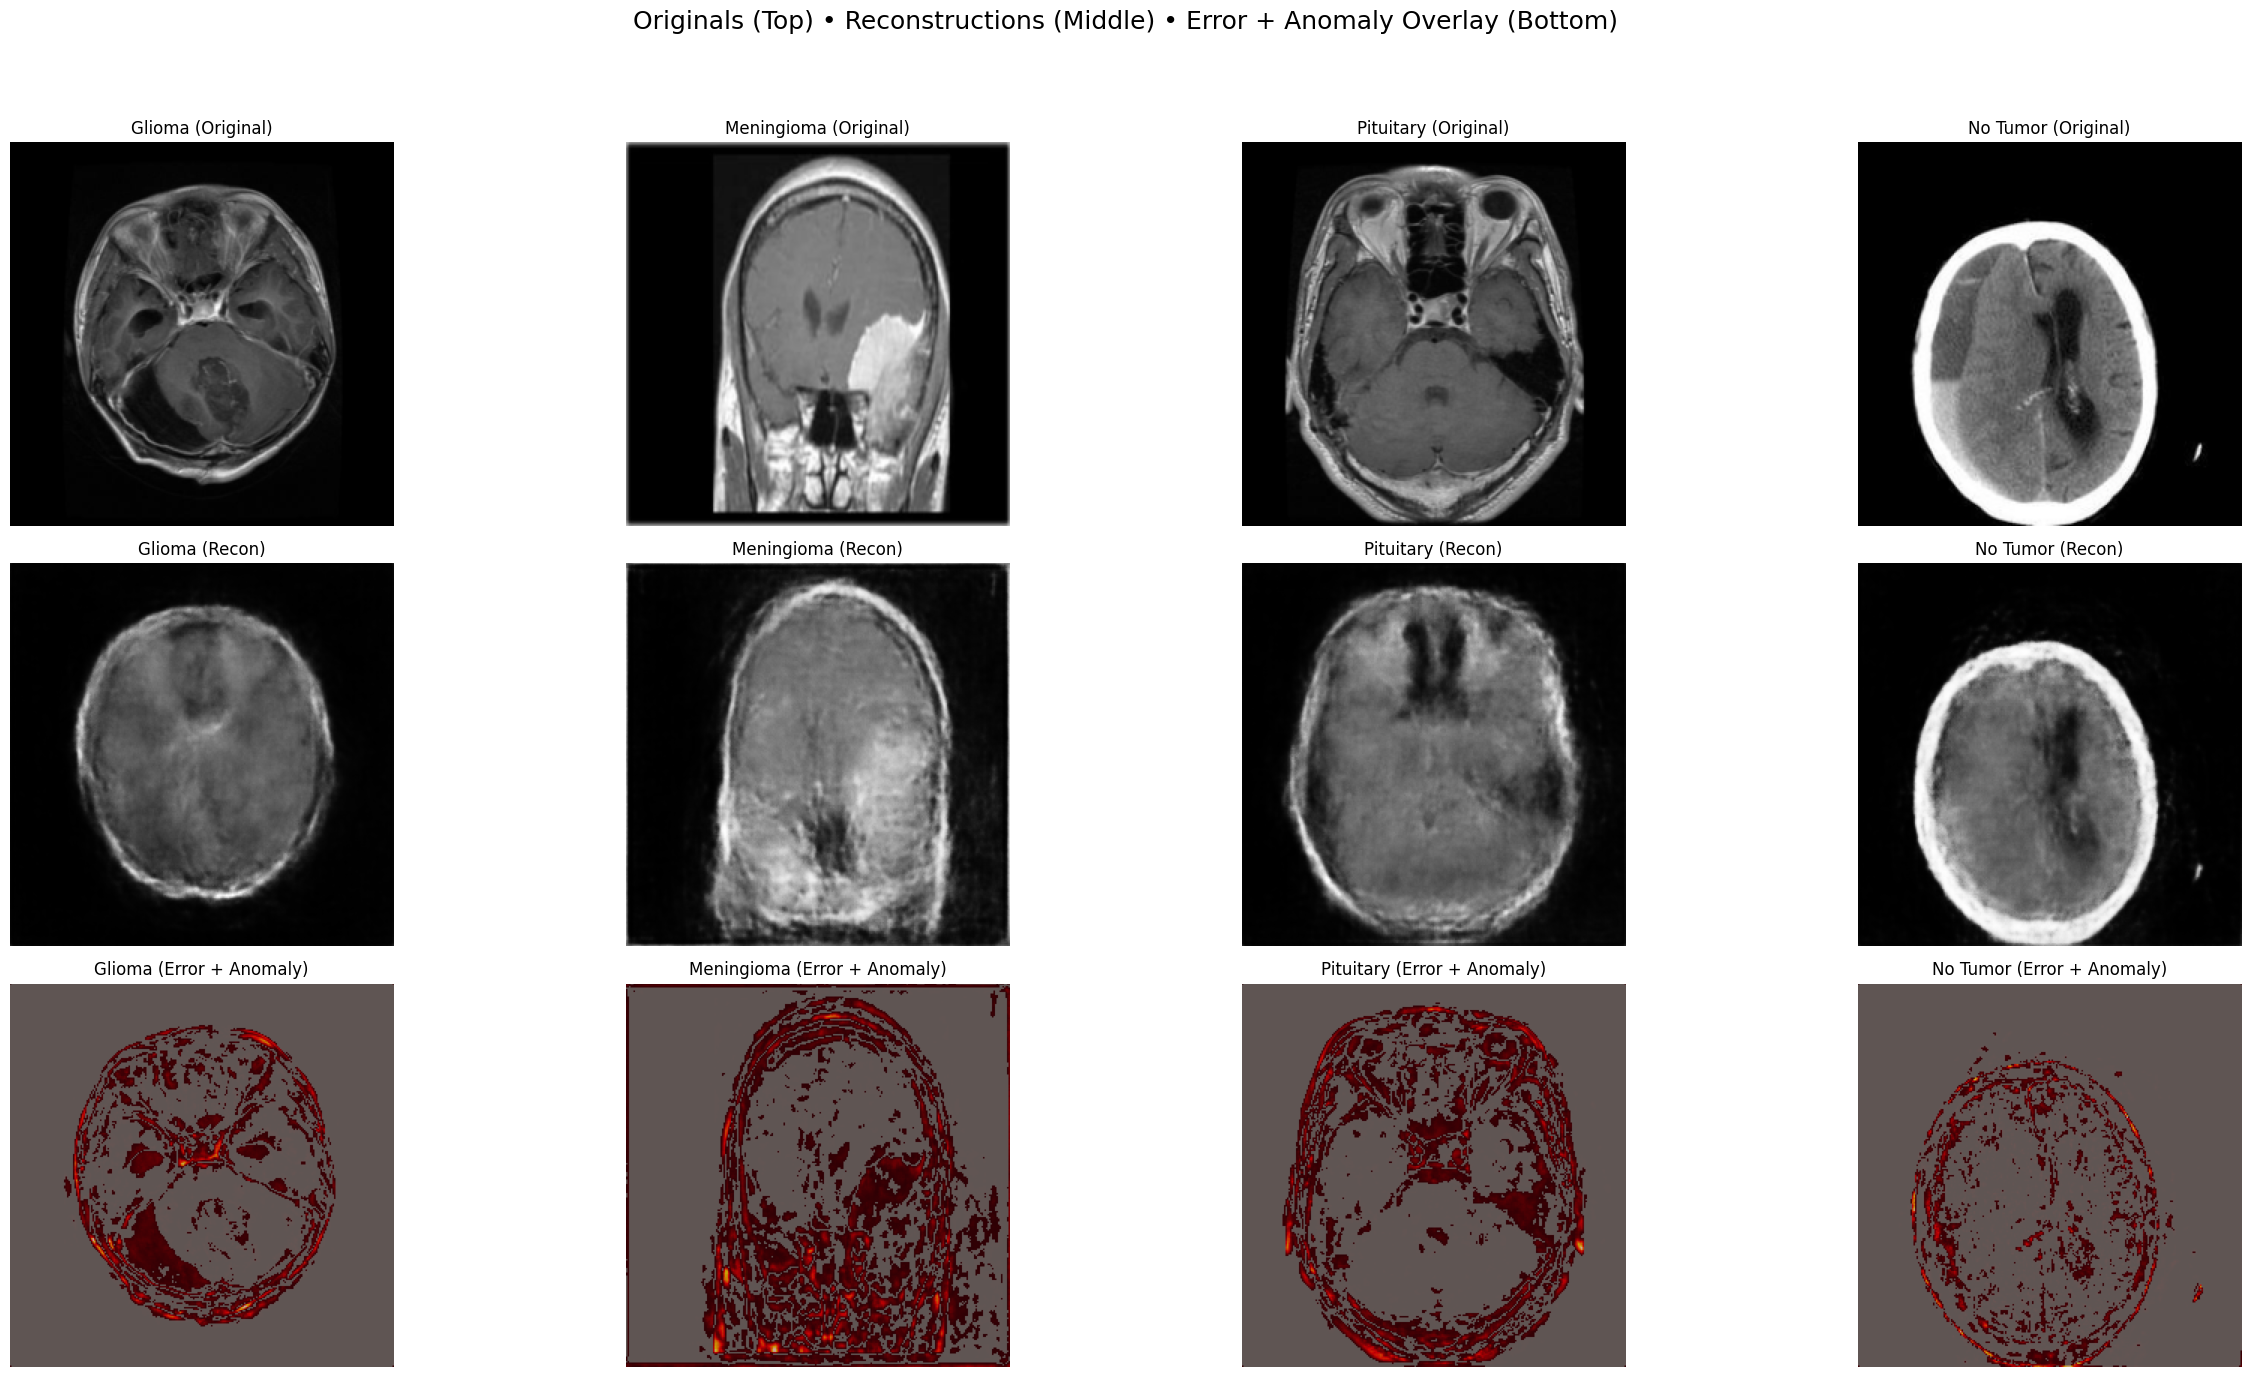

In [ ]:
# --- Visualize Reconstructions vs Original ---

fig, axes = plt.subplots(3, 4, figsize=(26, 14))
fig.suptitle(
    "Originals (Top) • Reconstructions (Middle) • Error + Anomaly Overlay (Bottom)",
    fontsize=18
)

# ---------- Helper to compute error + mask ----------
def error_and_mask(orig, recon, thresh):
    err = (orig - recon).pow(2).mean(dim=1)          # [B, H, W]
    mask = err > thresh                              # anomaly mask
    return err, mask


# ================== ORIGINALS ==================
out = vutils.make_grid(giloma_img.cpu()[:8], normalize=True)
axes[0, 0].imshow(out.permute(1, 2, 0))
axes[0, 0].set_title("Glioma (Original)")
axes[0, 0].axis("off")

out = vutils.make_grid(meningioma_img.cpu()[:8], normalize=True)
axes[0, 1].imshow(out.permute(1, 2, 0))
axes[0, 1].set_title("Meningioma (Original)")
axes[0, 1].axis("off")

out = vutils.make_grid(pituitary_img.cpu()[:8], normalize=True)
axes[0, 2].imshow(out.permute(1, 2, 0))
axes[0, 2].set_title("Pituitary (Original)")
axes[0, 2].axis("off")

out = vutils.make_grid(notumor_img.cpu()[:8], normalize=True)
axes[0, 3].imshow(out.permute(1, 2, 0))
axes[0, 3].set_title("No Tumor (Original)")
axes[0, 3].axis("off")


# ================== RECONSTRUCTIONS ==================
out = vutils.make_grid(giloma_recon.cpu()[:8], normalize=True)
axes[1, 0].imshow(out.permute(1, 2, 0))
axes[1, 0].set_title("Glioma (Recon)")
axes[1, 0].axis("off")

out = vutils.make_grid(meningioma_recon.cpu()[:8], normalize=True)
axes[1, 1].imshow(out.permute(1, 2, 0))
axes[1, 1].set_title("Meningioma (Recon)")
axes[1, 1].axis("off")

out = vutils.make_grid(pituitary_recon.cpu()[:8], normalize=True)
axes[1, 2].imshow(out.permute(1, 2, 0))
axes[1, 2].set_title("Pituitary (Recon)")
axes[1, 2].axis("off")

out = vutils.make_grid(notumor_recon.cpu()[:8], normalize=True)
axes[1, 3].imshow(out.permute(1, 2, 0))
axes[1, 3].set_title("No Tumor (Recon)")
axes[1, 3].axis("off")


# ================== ERROR + ANOMALY OVERLAY ==================
recon_thresh = recon_thresh  # your chosen threshold

err, mask = error_and_mask(giloma_img, giloma_recon, recon_thresh)
axes[2, 0].imshow(err[0].cpu(), cmap="hot")
axes[2, 0].imshow(mask[0].cpu(), cmap="Reds", alpha=0.35)
axes[2, 0].set_title("Glioma (Error + Anomaly)")
axes[2, 0].axis("off")

err, mask = error_and_mask(meningioma_img, meningioma_recon, recon_thresh)
axes[2, 1].imshow(err[0].cpu(), cmap="hot")
axes[2, 1].imshow(mask[0].cpu(), cmap="Reds", alpha=0.35)
axes[2, 1].set_title("Meningioma (Error + Anomaly)")
axes[2, 1].axis("off")

err, mask = error_and_mask(pituitary_img, pituitary_recon, recon_thresh)
axes[2, 2].imshow(err[0].cpu(), cmap="hot")
axes[2, 2].imshow(mask[0].cpu(), cmap="Reds", alpha=0.35)
axes[2, 2].set_title("Pituitary (Error + Anomaly)")
axes[2, 2].axis("off")

err, mask = error_and_mask(notumor_img, notumor_recon, recon_thresh)
axes[2, 3].imshow(err[0].cpu(), cmap="hot")
axes[2, 3].imshow(mask[0].cpu(), cmap="Reds", alpha=0.35)
axes[2, 3].set_title("No Tumor (Error + Anomaly)")
axes[2, 3].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()



In [ ]:
for p in [70, 75, 80, 85, 90,95,99]:
    t = np.percentile(normal_scores["recon"], p)
    y_pred = (y_scores > t).astype(int)
    print(
        f"p={p}: Recall={recall_score(y_true,y_pred):.3f}, "
        f"Precision={precision_score(y_true,y_pred):.3f}, "
        f"F1-score={f1_score(y_true,y_pred):.3f}, "
    )


p=70: Recall=0.917, Precision=0.872, F1-score=0.894, 
p=75: Recall=0.891, Precision=0.889, F1-score=0.890, 
p=80: Recall=0.847, Precision=0.904, F1-score=0.875, 
p=85: Recall=0.720, Precision=0.914, F1-score=0.805, 
p=90: Recall=0.485, Precision=0.915, F1-score=0.633, 
p=95: Recall=0.137, Precision=0.855, F1-score=0.236, 
p=99: Recall=0.050, Precision=0.900, F1-score=0.094, 


In [ ]:
recon_thresh = np.percentile(normal_scores["recon"], 70)

y_scores = np.concatenate([
    normal_scores["recon"],
    anomaly_scores["recon"]
])

y_pred = (y_scores > recon_thresh).astype(int)

print(classification_report(y_true,y_pred))


              precision    recall  f1-score   support

         0.0       0.79      0.70      0.74       405
         1.0       0.87      0.92      0.89       906

    accuracy                           0.85      1311
   macro avg       0.83      0.81      0.82      1311
weighted avg       0.85      0.85      0.85      1311



Text(120.72222222222221, 0.5, 'Prediction')

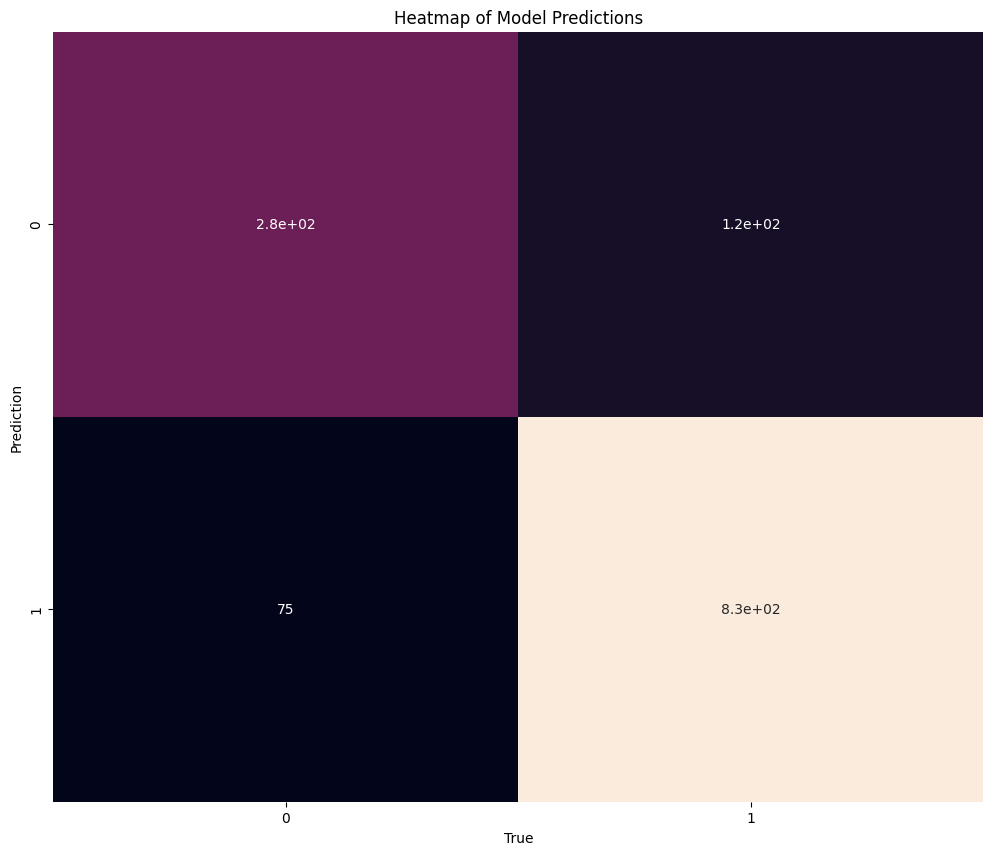

In [ ]:
# --- Plot Confusion Matrix ---
plt.figure(figsize = (12,10))
sns.heatmap(cm,annot=True,cbar=False)
plt.title('Heatmap of Model Predictions')
plt.xlabel('True')
plt.ylabel('Prediction')

In [ ]:
# --- Visualize PCA of Latent Space ---
def plot_latent_pca_3d_interactive(
    model,
    dataloader,
    device=None,
    color_by_label=False
):
    model.eval()
    device = device or next(model.parameters()).device

    zs = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                x, y = batch
                labels.append(y.cpu())
            else:
                x = batch

            x = x.to(device)
            _,mu, _ = model.encoder(x)

            # flatten spatial latents
            mu = mu.view(mu.size(0), -1)

            zs.append(mu.cpu())

    zs = torch.cat(zs, dim=0).numpy()

    pca = PCA(n_components=3)
    z_pca = pca.fit_transform(zs)

    if color_by_label and labels:
        labels = torch.cat(labels).numpy()
        fig = px.scatter_3d(
            x=z_pca[:, 0],
            y=z_pca[:, 1],
            z=z_pca[:, 2],
            color=labels.astype(str),
            labels={
                "x": "PC 1",
                "y": "PC 2",
                "z": "PC 3",
                "color": "Class"
            },
            title="Latent Space (3D PCA Projection)"
        )
    else:
        fig = px.scatter_3d(
            x=z_pca[:, 0],
            y=z_pca[:, 1],
            z=z_pca[:, 2],
            labels={
                "x": "PC 1",
                "y": "PC 2",
                "z": "PC 3"
            },
            title="Latent Space (3D PCA Projection)"
        )

    fig.update_traces(marker=dict(size=3))
    fig.show()


In [ ]:
plot_latent_pca_3d_interactive(
    vae,
    test_notumor_loader,
    color_by_label=True
)


In [ ]:
plot_latent_pca_3d_interactive(
    vae,
    test_anomaly_loader,
    color_by_label=True
)


In [ ]:

scores = {
    "normal": {
        "recon": normal_scores["recon"].tolist(),
        "kl": normal_scores["kl"].tolist(),
        "loss": normal_scores["score"].tolist(),
    },
    "anomaly": {
        "recon": anomaly_scores["recon"].tolist(),
        "kl": anomaly_scores["kl"].tolist(),
        "loss": anomaly_scores["score"].tolist(),
    },
    "metadata": {
        "percentile": 70,
        "threshold": float(recon_thresh),
        "auroc": float(auc),
        "beta": 0.0001,
        "model": "VAE",
        "classification_report": classification_report(y_true,y_pred)
    }
}

with open("vae_log/vae_scores.json", "w") as f:
    json.dump(scores, f, indent=2)
